# *Load the Libraries*

In [7]:
import numpy as np
import pandas as pd
import re
import random
import transformers
import matplotlib.pyplot as plt
import json
import pickle
import torch

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:

# Load dataset
import tabulate

df = pd.read_csv("../Data/mental_health_training.csv")
print("Dataset Overview:")
df.sample(n=5, random_state=42)

Dataset Overview:


,question,answer,pattern,tag
218,Where can I learn about types of mental health...,Mental health conditions are often treated wit...,Where can I learn about types of mental health...,fact-22
66,I feel so worthless.,It's only natural to feel this way. Tell me mo...,I feel so worthless.,worthless
9,Konnichiwa,Hello there. Tell me how are you feeling today?,Konnichiwa,greeting
170,i guess not,That's no problem. I can see why you'd be stre...,i guess not,no-approach
15,Good night,Good night. Get some proper sleep,Good night,night


In [9]:
# Creating intents dictionary
dict_ = {"intents": []}

for ind in df.index:
    question = df['question'][ind]
    if pd.notna(question):
        questions = question.lower().replace('?', '.').split('.')
    else:
        questions = []
    
    patterns = [q.strip() for q in questions if q.strip()]
    pattern = df['pattern'][ind]
    if pd.notna(pattern):
        patterns.append(pattern.lower().strip())
    
    responses = df['answer'][ind]
    tag = df['tag'][ind]

    dict1 = {'tags': [tag], 'patterns': patterns, 'responses': [responses]}
    dict_['intents'].append(dict1)
print(" Some Intents from the dataset:")
print(dict_["intents"][:2])

with open("../Data/intents.json", "w") as f:
    json.dump(dict_, f)

 Some Intents from the dataset:
[{'tags': ['greeting'], 'patterns': ['hi', 'hi'], 'responses': ['Hello there. Tell me how are you feeling today?']}, {'tags': ['greeting'], 'patterns': ['hey', 'hey'], 'responses': ['Hello there. Tell me how are you feeling today?']}]


In [10]:
import torch
from transformers import AutoTokenizer, AutoModel
from nltk.stem import WordNetLemmatizer
import pickle

# Load pre-trained BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']
lemmatizer = WordNetLemmatizer()

def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

for intent in dict_['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            word_list = tokenizer.tokenize(pattern)
            words.extend(word_list)
            documents.append((pattern, intent['tags'][0]))
            if intent['tags'][0] not in classes:
                classes.append(intent['tags'][0])

words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open('../Data/words.pkl', 'wb'))
pickle.dump(classes, open('../Data/classes.pkl', 'wb'))

c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expe

In [11]:
# Prepare training data
from sklearn.naive_bayes import LabelBinarizer



label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

training = []
for document in documents:
    pattern = document[0]
    tag = document[1]
    embedding = get_bert_embedding(pattern)
    output_row = label_binarizer.transform([tag])[0]
    training.append((embedding.flatten(), output_row))

random.shuffle(training)
training = np.array(training, dtype=object)

train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

In [12]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Split data into training and validation sets (80% training, 20% validation)
split_idx = int(0.8 * len(train_x))
X_train, X_val = train_x[:split_idx], train_x[split_idx:]
y_train, y_val = train_y[:split_idx], train_y[split_idx:]

# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

In [13]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

# Define model architecture with regularization (NO BATCH NORMALIZATION)
model = Sequential([
    Dense(128, input_shape=(len(train_x[1]),), activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),

    Dense(len(train_y[0]), activation='softmax')
])

# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Use the SGD optimizer with the learning rate schedule
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

# Compile with Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 79)                5135      
                                                                 
Total params: 111,823
Trainable params: 111,823
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist = model.fit(np.array(train_x), np.array(train_y), 
                 epochs=50, batch_size=12, 
                 validation_split=0.2, 
                 callbacks=[early_stop], 
                 verbose=1)

model.save('../model/conversationalchatbotmodel.h5', hist)
print('Training Complete')

Epoch 1/50
32/32 [==============================] - 2s 13ms/step - loss: 6.9921 - accuracy: 0.0187 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 6.4131 - val_accuracy: 0.0957 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 0s 3ms/step - loss: 6.0218 - accuracy: 0.0853 - precision: 1.0000 - recall: 0.0027 - val_loss: 5.5947 - val_accuracy: 0.1809 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
32/32 [==============================] - 0s 3ms/step - loss: 5.3323 - accuracy: 0.1333 - precision: 0.5000 - recall: 0.0080 - val_loss: 4.9586 - val_accuracy: 0.2340 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
32/32 [==============================] - 0s 3ms/step - loss: 4.7712 - accuracy: 0.2213 - precision: 0.6000 - recall: 0.0160 - val_loss: 4.5350 - val_accuracy: 0.3085 - val_precision: 1.0000 - val_recall: 0.0106
Epoch 5/50
32/32 [==============================] - 0s 3ms/step - loss: 4.3564 

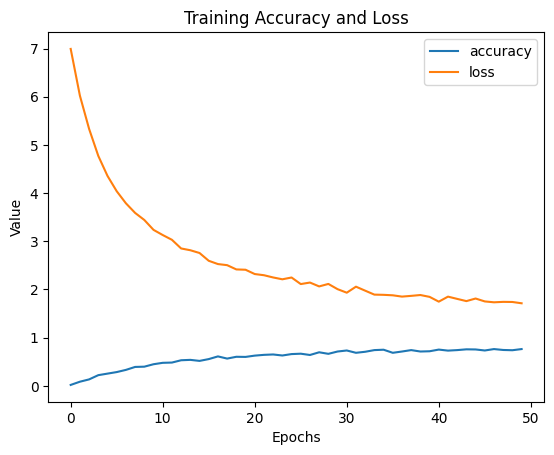

In [20]:

# Plot training accuracy and loss over epochs
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Accuracy and Loss')
plt.legend()
plt.show()

In [21]:
# Load the model for prediction
model = load_model('../model/conversationalchatbotmodel.h5')

def predict_class(sentence):
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]['intent']
    for i in intents_json['intents']:
        if tag in i['tags']:
            return random.choice(i['responses'])
    return "Sorry, I don't understand."

print("CHAT_BOT IS LIVE NOW....")

while True:
    message = input("")
    if message.lower() in ['quit', 'exit']:
        print("Goodbye")
        break
    ints = predict_class(message)
    if ints:
        res = get_response(ints, dict_)
        print(f"Bot: {res}")
    else:
        print("Bot: Sorry, I don't understand.")

CHAT_BOT IS LIVE NOW....
1/1 [==============================] - 0s 372ms/step
Bot: Hello there. Tell me how are you feeling today?
1/1 [==============================] - 0s 26ms/step
Bot: I'm sorry to hear that. I'm here for you. Talking about it might help. So, tell me why do you think you're feeling this way?
1/1 [==============================] - 0s 21ms/step
Bot: I'm sorry to hear that. I'm here for you. Talking about it might help. So, tell me why do you think you're feeling this way?
1/1 [==============================] - 0s 22ms/step
Bot: I'm sorry to hear that. I'm here for you. Talking about it might help. So, tell me why do you think you're feeling this way?
1/1 [==============================] - 0s 29ms/step
Bot: Oh I see. Tell me more
1/1 [==============================] - 0s 19ms/step
Bot: Sorry, I don't understand.
1/1 [==============================] - 0s 18ms/step
Bot: Sure. Tell me how can i assist you
1/1 [==============================] - 0s 28ms/step
Bot: Oh I see. 

In [22]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Evaluate the model
y_pred = model.predict(train_x)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class labels
y_true_classes = np.argmax(train_y, axis=1)  # Get the true class labels

# Calculate and print metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(report)

15/15 [==============================] - 0s 2ms/step
Accuracy: 0.9104
F1 Score: 0.8913
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.00      0.00      0.00         2
           2       1.00      0.75      0.86         4
           3       1.00      1.00      1.00         2
           4       0.96      1.00      0.98        22
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        16
           8       1.00      0.50      0.67         8
           9       1.00      1.00      1.00        10
          10       0.50      1.00      0.67         2
          11       0.50      1.00      0.67         4
          12       0.00      0.00      0.00         2
          13       1.00      1.00      1.00         2
          14       1.00      0.50      0.67         2
          15       1.00  

c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f